# XGBoost 

## Introduction 

XGBoost, also known as Extreme Gradient Boosting, is a supervised machine-learning model that uses decision trees. Like random forests it is an ensemble method, meaning multiple models are used to increase the accuracy of the model. Additionally, XGBoost can be used for classification and regression tasks like random forests. The difference between random forests and XGBoost is how the trees are built and combined. 

## Method 

Random forests use the ensemble learner bagging. Bagging is the method of randomly sampling a dataset with replacement to create a tree, which is done multiple times to create multiple trees each with its unique information. The final prediction is the average output of all the decision trees. Gradient Boosting on the other hand is a little different. The model uses something called boosting. Here are three easy steps for gradient boosting: 

1. A decision tree is created and with it comes a predicted target variable and residuals 
2. The next decision tree is fit to the residuals of the previous tree 
3. Lastly, the residuals and the new model work together to obtain a new tree that will have a lower loss function value than the previous 
4. This is repeated with the next tree built. The residuals of Tree 2 are fit to Tree 3 and the third tree's performance is improved based on the other two trees. 

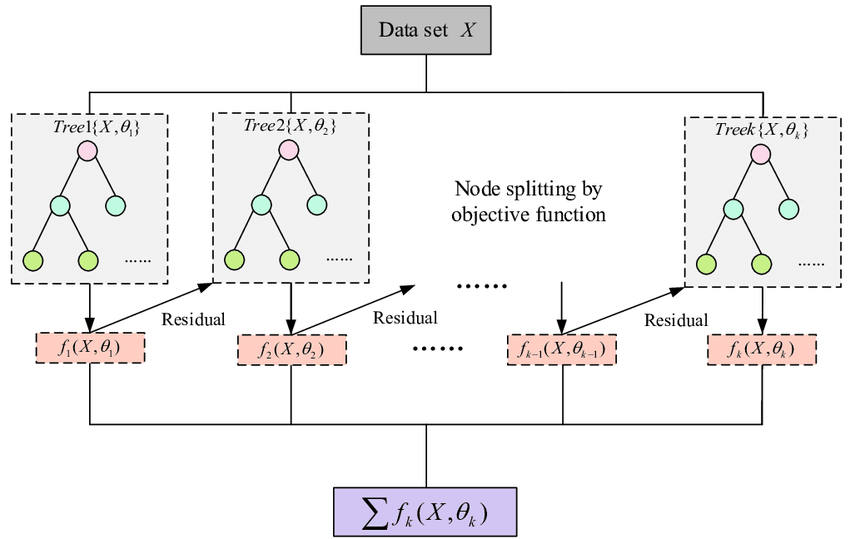



## Math 
XGBoost uses a gradient descent algorithm so that each new tree corrects the errors of the previous trees. To assess how well a tree does at predicting we use a loss function. There are many loss functions (OLS, Log-Loss, Cross-Entropy) that we can use that gradient descent can minimize. The goal of XGBoost is to minimize the loss compared to the first tree alone. 

$Boosted Ensemble$ = ($First Tree$ + $\eta$) * $Second Tree$

$Loss(Boosted Ensemble)$ < $Loss(First Tree)$

$\eta$ = Learning Rate 

### The General Model 

## $F(m)$ = $F(m-1)$ + $\eta$ * - $\frac{\delta L}{\delta f(m-1)}$ ##

This equation is saying that the model at step 'm' equals the model previous plus the learning rate times the negative derivative of loss concerning the previous model's output. When it comes to the learning rate, if it is too large it may go past the absolute minimum of our loss. However, if it is too small then it may take too long to converge to the absolute minimum. This means that we need to tune it to our data. 


## Advantages to XGBoost 

1. Uses regularization to pentalize complex models 
2. Handles sparse data well
3. Has the ability to use multiple cores for parallelization 
4. High Accuracy 
5. Handles large datasets 
6. Interpretable/Feature Importance 

Now we will show you had to run a basic XGBoost model in python.



### Packages 
Here are the needed packages for this tutorial 

In [7]:
import pandas as pd 
import numpy as np
import xgboost as xgb
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

### Dataset

We will be using the diamonds dataset. It has the features carat, cut, color, clarity, depth, table, x, y, and z. The response variable is the price of the diamond. For this example, we will be predicting the price of the diamond based on its characteristics. Before fitting our model we checked to see if there were any missing values. There appears to be none so we are good to move forward.

In [4]:
diamonds = sns.load_dataset("diamonds")


#Number of NA's 
print(diamonds.isna().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


### EDA 

Here we perform a quick EDA of our data. It appears that the higher the carat the higher the price of the diamond.

Text(0, 0.5, 'Price')

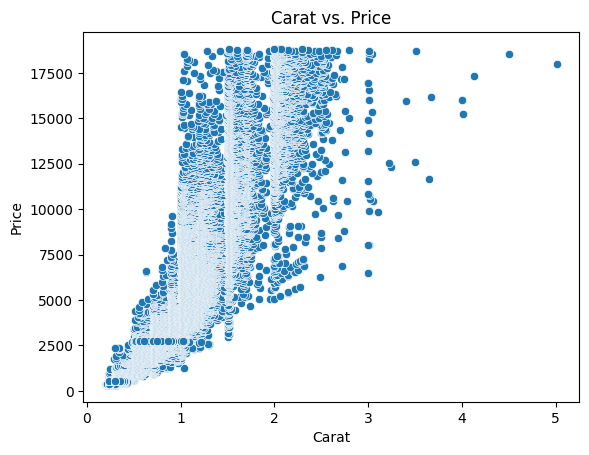

In [8]:
sns.scatterplot(x="carat", y="price", data=diamonds)

# Set plot title and axis labels
plt.title("Carat vs. Price")
plt.xlabel("Carat")
plt.ylabel("Price")

<Axes: xlabel='color', ylabel='price'>

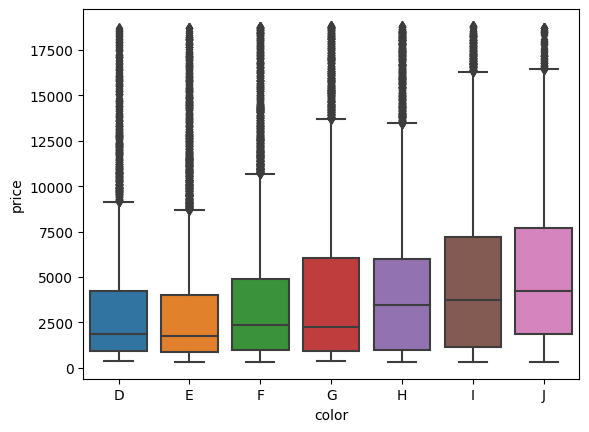

In [11]:
sns.boxplot(x="color", y="price", data=diamonds)

### Model Fit 
Before fitting the model we split the data and do preprocessing on our feature matrix. We want to make sure our categorical variables can be read by the XGBoost model correctly. 

In [17]:
#splitting the dataset 
X, y = diamonds.drop('price', axis=1), diamonds[['price']]

#changing the categorical variables 
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
X['cut'] = lbl.fit_transform(X['cut'].astype(str))
X['clarity'] = lbl.fit_transform(X['clarity'].astype(str))
X['color'] = lbl.fit_transform(X['color'].astype(str))

#splitting into test and train 

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=101)





### Hyper Tuning 
We used HyperOpt to tune the hyperparameters of our XGBoost Model. We create a space for all the possible values of our parameters that we care about. From there Hyperopt performs cross-validation and determines the best parameters. 

In [18]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from xgboost import XGBRegressor

# Choose hyperparameter domain to search over
space = {
        'max_depth':hp.choice('max_depth', np.arange(3, 5, 7, dtype=int)),
        'n_estimators':hp.choice('n_estimators', np.arange(100,200,300, dtype=int)),
        'learning_rate':hp.choice('learning_rate',np.arange(0.01, 0.5, 0.1, dtype=int)),
        'objective':'reg:squarederror',
        'eval_metric': 'rmse'
    }

def score(params):
    model = XGBRegressor(**params)
    
    model.fit(Xtrain, ytrain, eval_set=[(Xtrain, ytrain), (Xtest, ytest)],
              verbose=False)
    Y_pred = model.predict(Xtest)
    score = np.sqrt(mean_squared_error(ytest, Y_pred))
    return {'loss': score, 'status': STATUS_OK}    
    
def optimize(trials, space):
    
    best = fmin(score, space, algo=tpe.suggest, max_evals=100)
    return best

trials = Trials()
best_params = optimize(trials, space)

# Return the best parameters
space_eval(space, best_params)

100%|████████| 100/100 [00:40<00:00,  2.47trial/s, best loss: 5609.149377846183]


{'eval_metric': 'rmse',
 'learning_rate': 0,
 'max_depth': 3,
 'n_estimators': 100,
 'objective': 'reg:squarederror'}

### Predictions and Conclusion
After finding our best-tuned model we predict! We can just insert \**best_params into our model for the best parameters. We can see that our evaluation metric isn't that great which can be fixed with other preprocesses and tuning  This is a simple tutorial of how XGBoost is run in Python! If you need any 

In [21]:
#creating our best model 
model = xgb.XGBRegressor(**best_params)

#predictions 
preds = model.fit(Xtrain,ytrain).predict(Xtest)

print('MSE: ' + str(mean_squared_error(ytest,preds)))




MSE: 31462556.742992215
